In [1]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home-2/gsatopo1@jhu.edu/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pysm
import pysm3
from pysm.nominal import models
import healpy as hp
import time

grey='#324356'
turquoise='#54858a'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

## Calculation with pysm

`Sky` configuration dictionary. The keys specify which
components will be present; the items are lists
containing configuration dictionaries for each population of a component.


In [20]:
nside = 2**10
sky_config = {
    'synchrotron' : models("s1", nside),
    'dust' : models("d1", nside),
    'freefree' : models("f1", nside),
    'cmb' : models("c1", nside),
    'ame' : models("a1", nside),
}
sky_pysm = pysm.Sky(sky_config)

In [ ]:
cmb = sky.cmb(nu = 95.)
synch = sky.synchrotron(nu = 30)
dust = sky.dust(nu = 500)

fig = plt.figure(figsize=(13,8))
hp.mollview(cmb[0], min = -250, max = 250, title = 'cmb', sub=131)
hp.mollview(synch[0], min = 0, max = 200, title = 'synchrotron', sub=132)
hp.mollview(dust[0], min = 0, max = 1000, title = 'dust', sub=133)
plt.show()

As a test, we compute the mean and RMS of the different CMB and foreground components

In [3]:
freqs = np.logspace(np.log10(10), np.log10(600), 30)

total_mean = np.mean(sky.signal()(freqs), axis = 2)[:,0]
dust_mean = np.mean(sky.dust(freqs), axis = 2)[:,0]
synch_mean = np.mean(sky.synchrotron(freqs), axis = 2)[:,0]
ff_mean = np.mean(sky.freefree(freqs), axis = 2)[:,0]
ame_mean = np.mean(sky.ame(freqs), axis = 2)[:,0]
cmb_mean = np.mean(sky.cmb(freqs), axis = 2)[:,0]

total_rms = np.std(sky.signal()(freqs), axis = 2)[:,0]
dust_rms = np.std(sky.dust(freqs), axis = 2)[:,0]
synch_rms = np.std(sky.synchrotron(freqs), axis = 2)[:,0]
ff_rms = np.std(sky.freefree(freqs), axis = 2)[:,0]
ame_rms = np.std(sky.ame(freqs), axis = 2)[:,0]
cmb_rms = np.std(sky.cmb(freqs), axis = 2)[:,0]

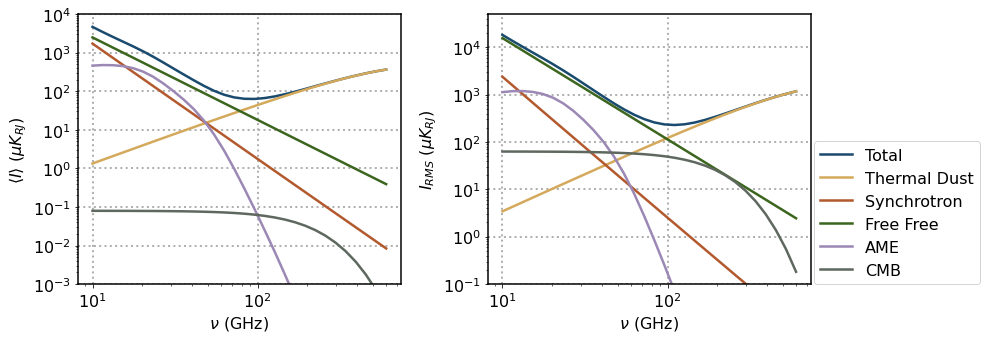

In [4]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.loglog(freqs, total_mean)
plt.loglog(freqs, dust_mean)
plt.loglog(freqs, synch_mean)
plt.loglog(freqs, ff_mean)
plt.loglog(freqs, ame_mean)
plt.loglog(freqs, cmb_mean)
plt.ylim(1e-3, 1e4)
plt.xlabel(r'$\nu$ (GHz)')
plt.ylabel(r'$\langle I \rangle$ ($\mu K_{RJ}$)')
plt.grid(linestyle='dotted', linewidth=2)

plt.subplot(1,2,2)
plt.loglog(freqs, total_rms, label='Total')
plt.loglog(freqs, dust_rms, label='Thermal Dust')
plt.loglog(freqs, synch_rms, label='Synchrotron')
plt.loglog(freqs, ff_rms, label='Free Free')
plt.loglog(freqs, ame_rms, label='AME')
plt.loglog(freqs, cmb_rms, label='CMB')
plt.legend(loc=(1.01,0))
plt.ylim(1e-1, 5e4)
plt.xlabel(r'$\nu$ (GHz)')
plt.ylabel(r'$I_{RMS}$ ($\mu K_{RJ}$)')
plt.grid(linestyle='dotted', linewidth=2)

plt.tight_layout()
plt.show()

## Compare pysm and pysm3

In [ ]:
nside = 2**10
sky_pysm3 = pysm3.Sky(nside=nside, preset_strings=["d1", "s1", "f1", "c1", "a1"])
nuObs=[30, 31, 32]

In [21]:
start = time.time()
map_pysm3=[sky.get_emission(i*u.GHz) for i in nuObs]
end = time.time()
print(end - start)

start = time.time()
map_pysm=sky_pysm.signal()(nuObs)[:,0,:]
end = time.time()
print(end - start)

14.218034029006958
34.18177151679993


### compare delta vs top hat window for fiducial spectral resolution in lightcone

In [2]:
nside = 2**9
sky = pysm3.Sky(nside=nside, preset_strings=["d1", "s1", "f1", "c1", "a1"])

nu_CO=115.271*u.GHz
z=2.5
R=700
nuObs=nu_CO/(1+z)
dnu=nu_CO/(1+z)/R
nus=np.linspace(nuObs-dnu/2, nuObs+dnu/2, 11)

map_delta=sky.get_emission(nuObs)
map_tophat=sky.get_emission(nus)

hp.mollview(map_delta[0]-map_tophat[0])
plt.show()

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


KeyboardInterrupt: 

## Rotation and survey selection

After creating maps of the galactic foreground and the CMB, we must to add them to the 3d lightcone map. The procedure can be summarized as follows

1. Produce foreground maps at the observed frequency channels
2. Rotate foreground maps so that the center of the observed footprint is at the origin of the coordinate system (hence matching the lightcone coordinates)
3. Select pixels within the survey mask and map pixel positions and frequencies onto 3d coordinates

We begin by demonstrating the rotation procedure of the healpix maps by placing the galactic south pole at the center of the observed map

In [8]:
from mpi4py import MPI

In [7]:
def tp2ra(theta, phi):    
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    return ra, dec

def observed_mask_2d(nside, ra_min, ra_max, dec_min, dec_max):
    pix = np.arange(hp.nside2npix(nside), dtype=int)
    theta, phi = hp.pix2ang(nside, pix)
    ra, dec = tp2ra(theta, phi)

    DEC_mask=(dec>dec_min)&(dec<=dec_max)
    ra[ra>180]=ra[ra>180]-360
    RA_mask=(ra>ra_min)&(ra<=ra_max)

    mask=RA_mask&DEC_mask
    return mask

nside = 32
pix_mask = observed_mask_2d(nside, -10, 10, -10, 10)
pixel_indices=np.arange(hp.nside2npix(nside), dtype=int)[pix_mask]    

map_dist = pysm3.MapDistribution(pixel_indices=pixel_indices, nside=nside, mpi_comm=MPI.COMM_WORLD)
sky = pysm3.Sky(nside=nside, preset_strings=["d1", "s1", "f1", "a1"], map_dist=map_dist)
m = sky.get_emission(freq=np.arange(50, 55) * u.GHz, weights=np.array([0.1, 0.3, 0.5, 0.3, 0.1]))[0]

print(map_dist.mpi_comm.rank, m.shape, m.min(), m.max())

m_smoothed = pysm3.apply_smoothing_and_coord_transform(m, fwhm=1 * u.deg, map_dist=map_dist)
print(map_dist.mpi_comm.rank, m_smoothed.shape, m_smoothed.min(), m_smoothed.max())

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


0 (128,) 74.05630493164062 uK_RJ 12049.841796875 uK_RJ


TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [9]:
def tp2ra(theta, phi):    
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    return ra, dec

def observed_mask_2d(nside, ra_min, ra_max, dec_min, dec_max):
    pix = np.arange(hp.nside2npix(nside), dtype=int)
    theta, phi = hp.pix2ang(nside, pix)
    ra, dec = tp2ra(theta, phi)

    DEC_mask=(dec>dec_min)&(dec<=dec_max)
    ra[ra>180]=ra[ra>180]-360
    RA_mask=(ra>ra_min)&(ra<=ra_max)

    mask=RA_mask&DEC_mask
    return mask

nside = 2**9
pix_mask = observed_mask_2d(nside, -10, 10, -10, 10)
pixel_indices=np.arange(hp.nside2npix(nside), dtype=int)[pix_mask]    

map_dist = pysm3.MapDistribution(pixel_indices=None, nside=nside, mpi_comm=MPI.COMM_WORLD)
sky = pysm3.Sky(nside=nside, preset_strings=["d1", "s1", "f1", "a1"], map_dist=map_dist)

galmap=sky.get_emission(30*u.GHz)[0]#produce healpy maps, 0 index corresponds to intensity

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [10]:
proj=hp.projector.CartesianProj(rot=[0, 90], xsize=100, lonra =  [-10, 10], latra=[-10, 10])

In [17]:
#Xpix=np.arange(0, LC_CO.Nside[0])
#Ypix=np.arange(0, LC_CO.Nside[1])
#pix=np.asarray([(x, y) for x in Xpix for y in Ypix])

i,j=np.meshgrid(np.arange(0, 100), np.arange(0,100))

In [19]:
X,Y=np.asarray(proj.ij2xy(i,j))
print(np.max(Y))

10.0


In [24]:
np.diff(X[:,0])

array([0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202, 0.2020202,
       0.2020202, 0.2020202, 0.2020202, 0.2020202, 

In [17]:
np.ones((len(X.flatten())))


array([1., 1., 1., ..., 1., 1., 1.])

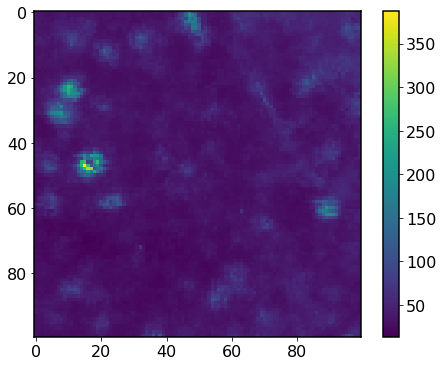

In [15]:
def func(x1, x2, x3):
    return hp.vec2pix(2**9, x1, x2, x3)
gal_cart=proj.projmap(galmap, func)

plt.imshow(gal_cart)
plt.colorbar()

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a

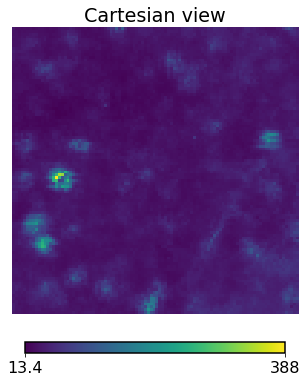

In [16]:
gal_cart = hp.cartview(galmap, xsize=100, lonra =  [-10, 10], latra=[-10, 10], 
                       return_projected_map=True, 
                       rot=[0, 90])

In [20]:
rot_center = hp.Rotator(rot=[0, 90], inv=True) #rotation to place the center of the survey at the origin
galmap_rotated=rot_center.rotate_map_pixel(galmap) #apply rotation
galmap_rotated = hp.smoothing(galmap_rotated, fwhm=(2*u.arcmin).to_value(u.rad))

pix_mask = np.logical_not(observed_mask_2d(nside, -10, 10, -10, 10))
masked_map=np.copy(galmap_rotated)
masked_map[pix_mask]=hp.UNSEEN

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.849322 arcmin (0.000247 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 2.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


In [57]:
phicorner = np.deg2rad(np.array([-10,-10,10,10])) #ra
thetacorner = np.pi/2-np.deg2rad(np.array([10,-10,-10,10])) #dec
vecs = hp.dir2vec(thetacorner,phi=phicorner).T
pix_within = hp.query_polygon(nside=2**9,vertices=vecs,inclusive=False)
mask = np.ones(hp.nside2npix(2**9),np.bool)
mask[pix_within] = 0
hp_map = hp.ma(galmap)
hp_map.mask = mask

In [ ]:
theta, phi = hp.pix2ang(2**9, pix_within)
ra, dec = tp2ra(theta, phi)
ra[ra>180]=ra[ra>180]-360


In [63]:
np.max(ra)

359.912109375

In [21]:
hp.mollview(hp_map.filled(), min = -250, max = 1000)

NameError: name 'hp_map' is not defined

<Figure size 1080x1080 with 0 Axes>

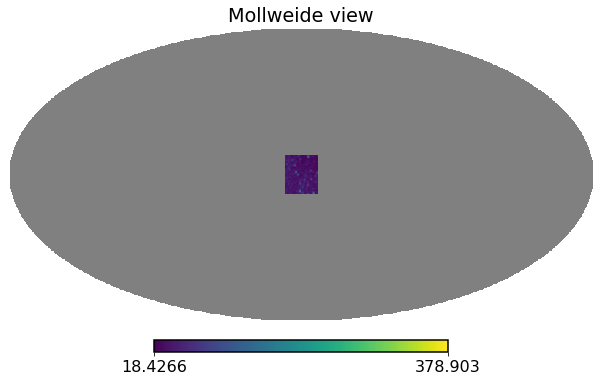

In [24]:
plt.figure(figsize=(15,15))
hp.mollview(masked_map)

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


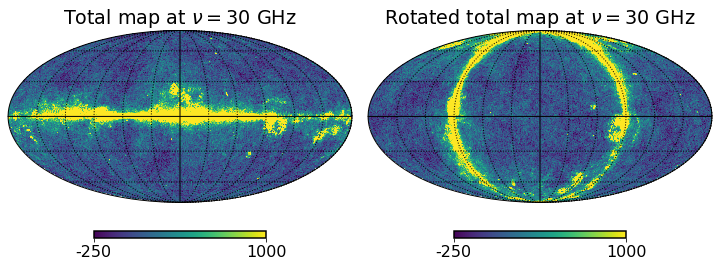

In [4]:
obs_freq=np.linspace(26, 34, 5)
tot_map=sky.signal()(obs_freq)[:,0,:]

rot_southpole = hp.Rotator(rot=[0, 90], inv=True)
tot_map_rotated=[]
for i in range(len(obs_freq)):
    tot_map_rotated.append(rot_southpole.rotate_map_pixel(tot_map[i]))

fig = plt.figure(figsize=(10,8))
hp.mollview(tot_map[2], min = -250, max = 1000, title=r'Total map at $\nu = 30$ GHz', sub=121)
hp.mollview(tot_map_rotated[2], min = -250, max = 1000, title=r'Rotated total map at $\nu = 30$ GHz', sub=122)
hp.graticule()

Compute residuals to assess the rotation precision...

In [5]:
inv_rot_southpole = hp.Rotator(rot=[0, -90], inv=True)
inv_tot_map_rotated=[]
for i in range(len(obs_freq)):
    inv_tot_map_rotated.append(inv_rot_southpole.rotate_map_pixel(tot_map_rotated[i]))

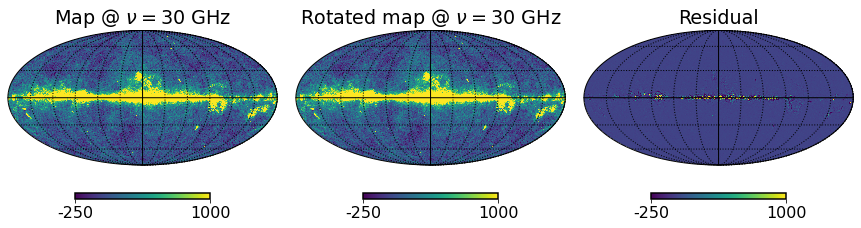

In [6]:
fig = plt.figure(figsize=(12,8))
hp.mollview(tot_map[2], min = -250, max = 1000, title=r'Map @ $\nu = 30$ GHz', sub=131)
hp.mollview(inv_tot_map_rotated[2], min = -250, max = 1000, title=r'Rotated map @ $\nu = 30$ GHz', sub=132)
hp.mollview(tot_map[2]-inv_tot_map_rotated[2], min = -250, max = 1000, title=r'Residual', sub=133)
hp.graticule()

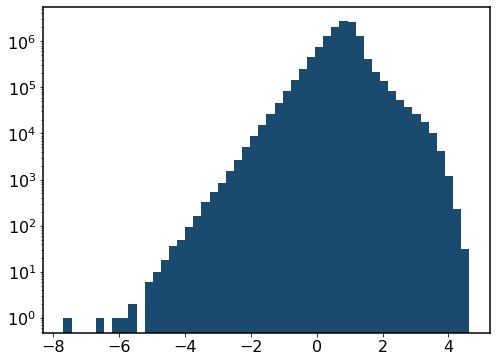

In [15]:
plt.hist(np.log10(abs(tot_map[2]-inv_tot_map_rotated[2])), bins=50, log=True)
plt.show()

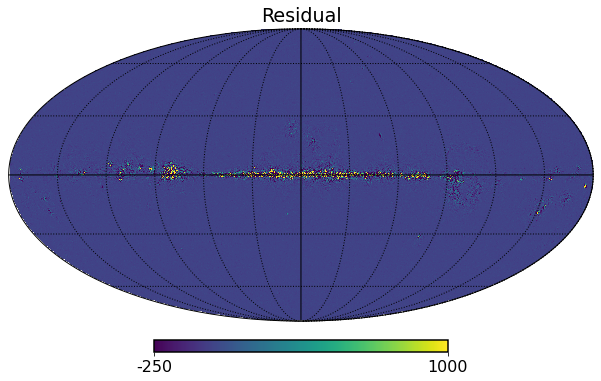

In [7]:
hp.mollview(tot_map[2]-inv_tot_map_rotated[2], min = -250, max = 1000, title=r'Residual')
hp.graticule()

We then select the region of the map within the observed cubic footprint

In [34]:
def tp2ra(theta, phi):    
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    return ra, dec

def observed_mask_2d(nside, ra_min, ra_max, dec_min, dec_max):
    pix = np.arange(hp.nside2npix(nside), dtype=int)
    theta, phi = hp.pix2ang(nside, pix)
    ra, dec = tp2ra(theta, phi)

    DEC_mask=(dec>dec_min)&(dec<=dec_max)
    ra[ra>180]=ra[ra>180]-360
    RA_mask=(ra>ra_min)&(ra<=ra_max)

    mask=RA_mask&DEC_mask
    return mask

pix_mask = np.logical_not(observed_mask_2d(nside, -10, 10, -10, 10))
masked_map=np.copy(galmap)
masked_map[pix_mask]=hp.UNSEEN
hp.mollview(masked_map, min = -250, max = 1000, coord='G')
hp.graticule()

UnitConversionError: '' (dimensionless) and 'uK_RJ' are not convertible

In [17]:
masked_map

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

In [21]:
hp.fitsfunc.write_map('../../test_map',masked_map, coord='G', dtype=np.float32)

## Lightcone implementation

In [ ]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home-2/gsatopo1@jhu.edu/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pysm
from pysm.nominal import models
import healpy as hp
import time

grey='#324356'
turquoise='#54858a'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [14]:
def LC_params():
    h=0.678
    nu_CO=115.271*u.GHz
    zmin_CO = 2.5; zmax_CO = 2.51; zmid_CO=(zmax_CO+zmin_CO)/2

    R=700
    dnu=nu_CO/(1+zmid_CO)/R
    nuObs_max=nu_CO/(1+zmin_CO); nuObs_min=nu_CO/(1+zmax_CO); delta_nuObs=nuObs_max - nuObs_min
    Nchan=int(np.round((delta_nuObs/(dnu)).decompose()))
    print(Nchan)
    
    foreground_path='/home-2/gsatopo1@jhu.edu/scratch/gal-foreground-maps/'
    foreground_files=[foreground_path+'foreground_CO_'+str(i)+'.fits' for i in range(Nchan)]

    model_params=dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/', 
                      lines=dict(CO_J10=True), target_line = 'CO_J10',
                      models=dict(CO_J10=dict(model_name='CO_Li16',
                                          model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      supersample=1,
                      Nmu=20,
                      dk=0.02*u.Mpc**-1,
                      do_intensity=False,
                      seed=0,
                      nside=2**12,
                      do_gal_foregrounds=False,
                      foreground_model=dict(precomputed_file=foreground_files, dgrade_nside=2**10, 
                                            survey_center=[0*u.deg, 90*u.deg], 
                                            sky={'synchrotron' : True, 
                                                 'dust' : True, 
                                                 'freefree' : True,
                                                 'ame' : True}))
    obs_params=dict(zmin = zmin_CO-0.03, zmax = zmax_CO+0.03,
                    RAObs_min=-1*u.deg,RAObs_max=1*u.deg,
                    DECObs_min=-1*u.deg,DECObs_max=1*u.deg,
                    RA_min=-1*u.deg,RA_max=1*u.deg,
                    DEC_min=-1*u.deg,DEC_max=1*u.deg,
                    nuObs_max=nuObs_max, nuObs_min=nuObs_min,
                    dnu=dnu,
                    Tsys=0*u.Jy/u.sr,
                    #Tsys=0*u.K,
                    #Tsys=(45*u.K/(69.4)**0.5)*np.sqrt(4/400),
                    Nfeeds=19*2,
                    beam_FWHM=2*u.arcmin,
                    tobs=1000*u.hr,
                    do_angular_smooth=True)
    obs_params.update(model_params)
    return obs_params

In [15]:
LC_CO=make_measurements(LC_params())

2


In [16]:
LC_CO.Nside

(60, 60)

In [17]:
start = time.time()
CO_map=LC_CO.obs_3d_map

end = time.time()
print(end - start)

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
2.4744365215301514


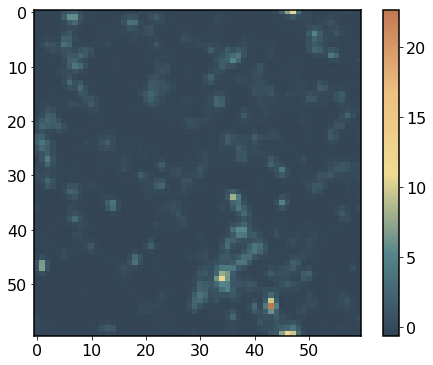

In [18]:
plt.imshow(CO_map[0], cmap=cmap)
plt.colorbar()

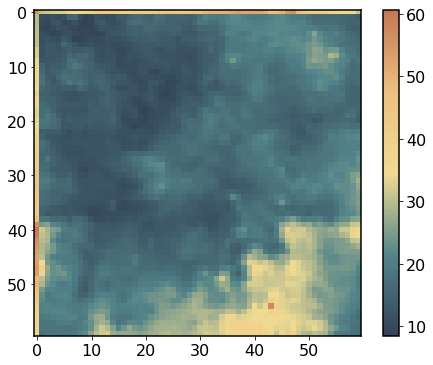

In [5]:
plt.imshow(CO_map[0], cmap=cmap)
plt.colorbar()

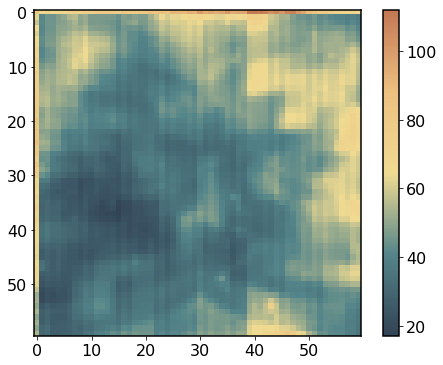

In [5]:
plt.imshow(CO_map[0], cmap=cmap)
plt.colorbar()

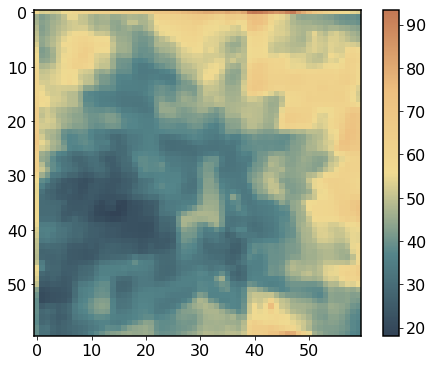

In [9]:
plt.imshow(CO_map[0], cmap=cmap)
plt.colorbar()

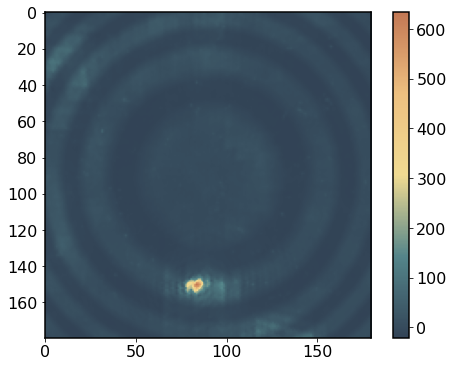

In [30]:
plt.imshow(CO_map[0], cmap=cmap)
plt.colorbar()

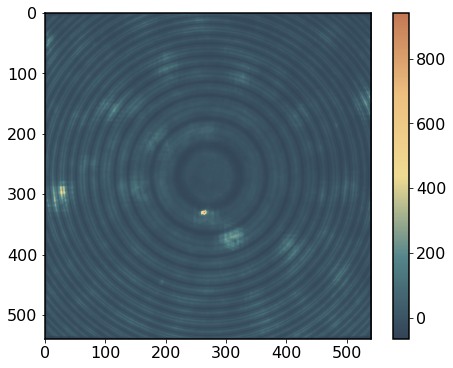

In [19]:
plt.imshow(CO_map[0], cmap=cmap)
plt.colorbar()

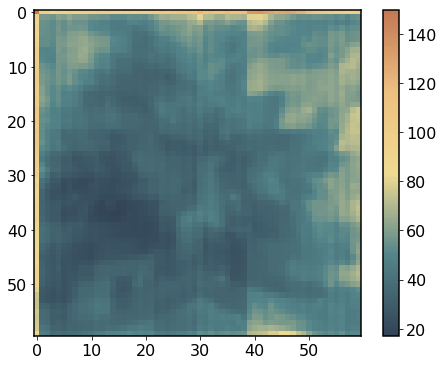

In [5]:
plt.imshow(CO_map[0], cmap=cmap)
plt.colorbar()

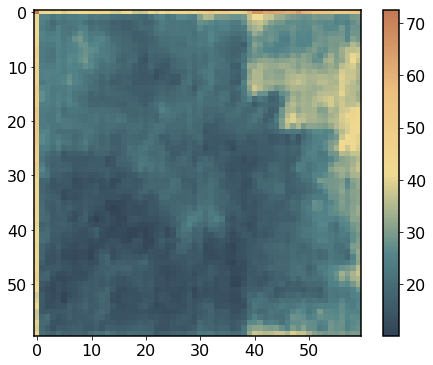

In [9]:
plt.imshow(CO_map[0], cmap=cmap)
plt.colorbar()

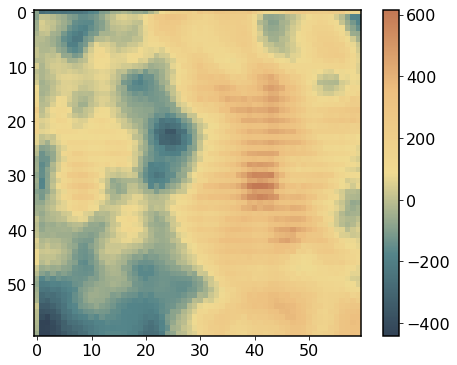

In [5]:
plt.imshow(CO_map[0,:,:], cmap=cmap)
plt.colorbar()

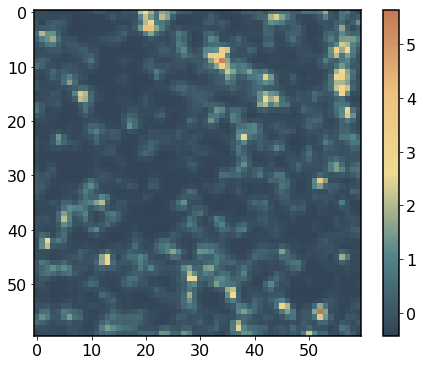

In [36]:
plt.imshow(CO_map[0,:,:], cmap=cmap)
plt.colorbar()

In [35]:
CO_map.shape

(5, 60, 60)

In [5]:
foreground_map=hp.fitsfunc.read_map('/home-2/gsatopo1@jhu.edu/scratch/gal-foreground-maps/foreground_CO_0.fits') 

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a

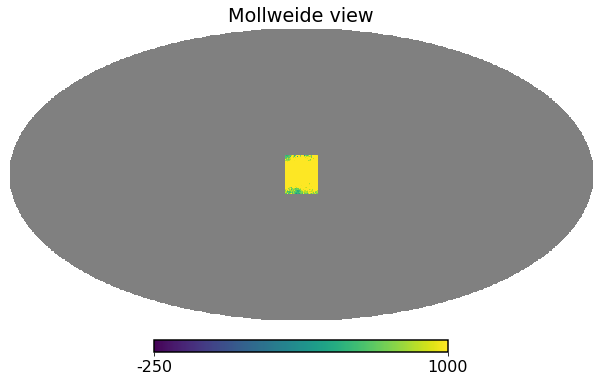

In [7]:
hp.mollview(foreground_map, min = -250, max = 1000)
